# A/B テスト結果の分析

baseline（フィードバックA）と ours（フィードバックB）の比較結果を可視化します。

In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import japanize_matplotlib
import numpy as np
from pathlib import Path
from collections import Counter

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

## 1. データの読み込み

In [2]:
# 結果ファイルを読み込み
results_path = Path("results/abtest_results.jsonl")

if not results_path.exists():
    print(f"ファイルが見つかりません: {results_path}")
else:
    # JSON Lines を DataFrame に変換
    df = pd.read_json(results_path, lines=True)
    print(f"読み込みデータ: {len(df)} 行")
    print(f"\n列一覧: {list(df.columns)}")
    df.head()

読み込みデータ: 20 行

列一覧: ['timestamp', 'user_id', 'item_index', 'source_userid', 'baseline_on_left', 'kyushu_student', 'info_course_taken', 'info_course_grade', 'accuracy', 'readability', 'persuasiveness', 'actionability', 'hallucination', 'usefulness', 'overall', 'comment']


## 2. 評価値を標準化（Baseline有利→正、Ours有利→負）

In [3]:
# RATING_SCALE のマッピング
# "A が強く良い", "A がやや良い", "どちらとも言えない", "B がやや良い", "B が強く良い"
rating_to_score = {
    "A が強く良い": 2,
    "A がやや良い": 1,
    "どちらとも言えない": 0,
    "B がやや良い": -1,
    "B が強く良い": -2,
}

# 評価項目
rating_fields = [
    "usefulness",
    "readability",
    "persuasiveness",
    "actionability",
    "hallucination",
    "overall",
]

# baseline_on_left を使って Baseline vs Ours のスコアに変換
# baseline_on_left=True のとき Baseline=A, False のとき Baseline=B なので、
# A側有利スコアに Baseline が A なら +1, B なら -1 を掛ける。
sign = df["baseline_on_left"].map({True: 1, False: -1})
for field in rating_fields:
    base_score = df[field].map(rating_to_score)
    df[f"{field}_score"] = base_score * sign

print("変換完了（正=Baseline有利、負=Ours有利）")
df[["usefulness", "usefulness_score"]].head()

変換完了（正=Baseline有利、負=Ours有利）


,usefulness,usefulness_score
0,A がやや良い,-1
1,B が強く良い,-2
2,B がやや良い,-1
3,A がやや良い,-1
4,どちらとも言えない,0


## 3. 全体の勝敗集計

In [4]:
# 各フィールドごとの勝敗を集計
results_summary = {}

for field in rating_fields:
    score_col = f"{field}_score"

    a_wins = (df[score_col] > 0).sum()
    ties = (df[score_col] == 0).sum()
    b_wins = (df[score_col] < 0).sum()

    results_summary[field] = {
        "Baseline (A) 勝利": a_wins,
        "同程度": ties,
        "Ours (B) 勝利": b_wins,
    }

summary_df = pd.DataFrame(results_summary).T
print("\n=== 評価項目ごとの勝敗集計 ===")
print(summary_df)
print(f"\n総回答数: {len(df)}")


=== 評価項目ごとの勝敗集計 ===
                Baseline (A) 勝利  同程度  Ours (B) 勝利
usefulness                    0    7           13
readability                   1   14            5
persuasiveness                0   11            9
actionability                 1    7           12
hallucination                 0    9           11
overall                       0    8           12

総回答数: 20


## 4. 平均スコアの計算

In [5]:
# 各フィールドの平均スコアを計算（正=A有利、負=B有利）
avg_scores = {}
for field in rating_fields:
    score_col = f"{field}_score"
    avg_scores[field] = df[score_col].mean()

print("\n=== 平均スコア（正=A有利、負=B有利） ===")
for field, score in avg_scores.items():
    direction = "A有利" if score > 0 else "B有利" if score < 0 else "同程度"
    print(f"{field:20s}: {score:+.3f}  ({direction})")


=== 平均スコア（正=A有利、負=B有利） ===
usefulness          : -0.800  (B有利)
readability         : -0.200  (B有利)
persuasiveness      : -0.500  (B有利)
actionability       : -0.550  (B有利)
hallucination       : -0.550  (B有利)
overall             : -1.000  (B有利)


## 5. 棒グラフ：項目ごとの勝敗（積み上げ）

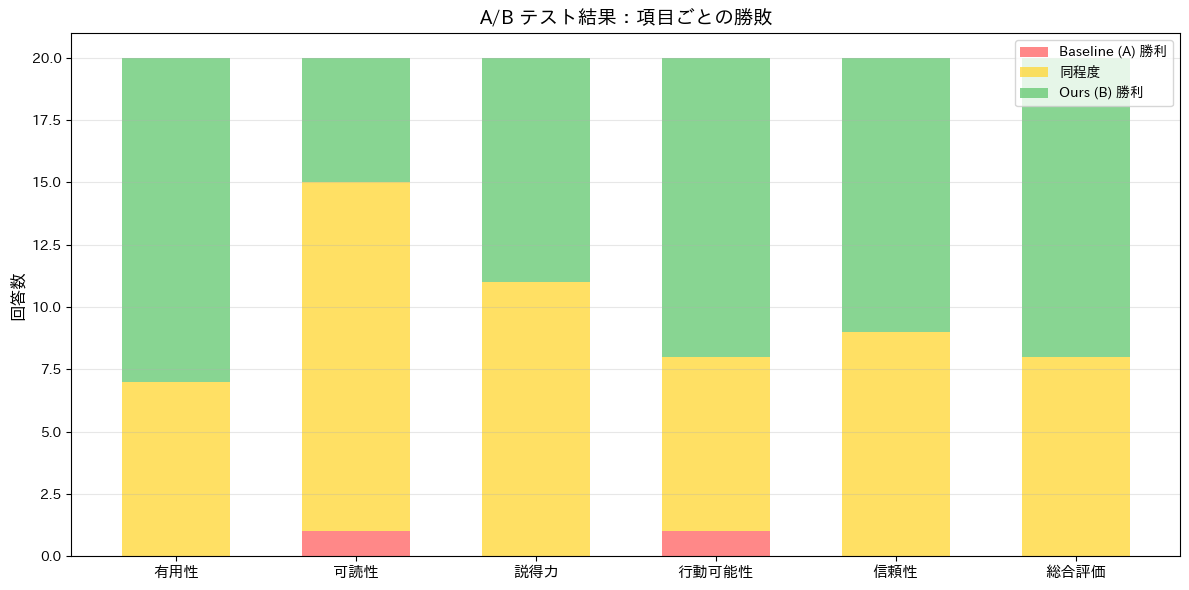

In [6]:
# 日本語ラベル
field_labels = {
    "usefulness": "有用性",
    "readability": "可読性",
    "persuasiveness": "説得力",
    "actionability": "行動可能性",
    "hallucination": "信頼性",
    "overall": "総合評価",
}

fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(rating_fields))
width = 0.6

a_wins_list = [summary_df.loc[f, "Baseline (A) 勝利"] for f in rating_fields]
ties_list = [summary_df.loc[f, "同程度"] for f in rating_fields]
b_wins_list = [summary_df.loc[f, "Ours (B) 勝利"] for f in rating_fields]

ax.bar(x, a_wins_list, width, label="Baseline (A) 勝利", color="#FF6B6B", alpha=0.8)
ax.bar(x, ties_list, width, bottom=a_wins_list, label="同程度", color="#FFD93D", alpha=0.8)
ax.bar(x, b_wins_list, width, bottom=np.array(a_wins_list) + np.array(ties_list),
       label="Ours (B) 勝利", color="#6BCB77", alpha=0.8)

ax.set_ylabel("回答数", fontsize=12)
ax.set_title("A/B テスト結果：項目ごとの勝敗", fontsize=14, fontweight="bold")
ax.set_xticks(x)
ax.set_xticklabels([field_labels[f] for f in rating_fields], fontsize=11)
ax.legend(fontsize=10)
ax.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.savefig("results/01_wins_by_field.png", dpi=300, bbox_inches="tight")
plt.show()

## 6. 折れ線グラフ：平均スコアの比較

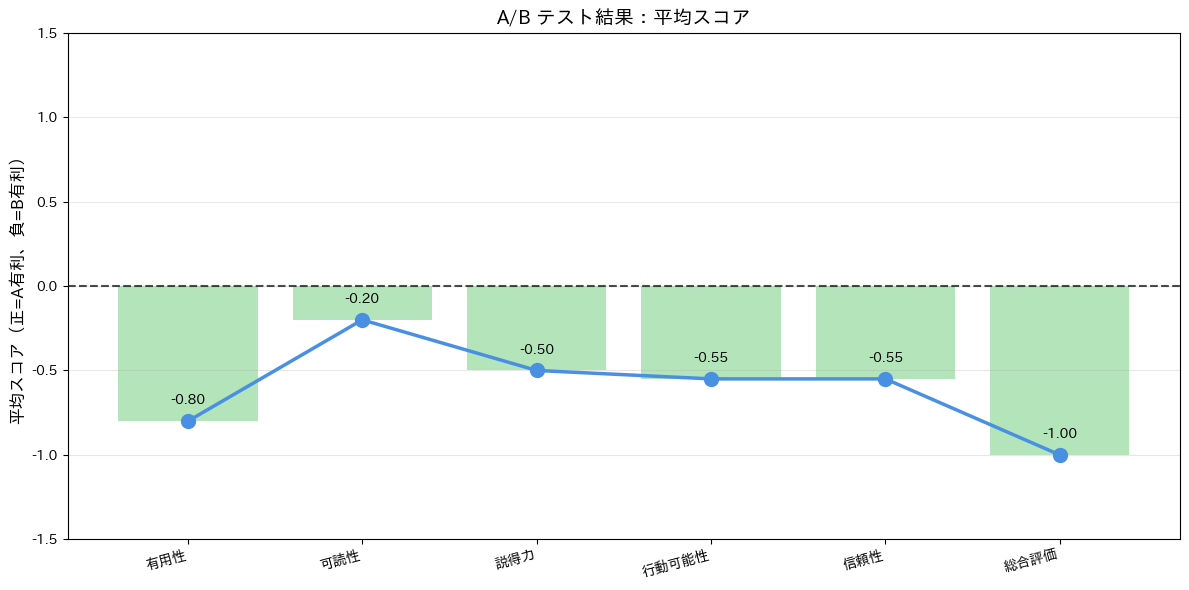

In [7]:
fig, ax = plt.subplots(figsize=(12, 6))

scores = [avg_scores[f] for f in rating_fields]
labels = [field_labels[f] for f in rating_fields]

colors = ["#FF6B6B" if s > 0 else "#6BCB77" if s < 0 else "#FFD93D" for s in scores]

ax.plot(labels, scores, marker="o", linewidth=2.5, markersize=10, color="#4A90E2")
ax.bar(labels, scores, alpha=0.5, color=colors)
ax.axhline(y=0, color="black", linestyle="--", linewidth=1.5, alpha=0.7)

ax.set_ylabel("平均スコア（正=A有利、負=B有利）", fontsize=12)
ax.set_title("A/B テスト結果：平均スコア", fontsize=14, fontweight="bold")
ax.grid(axis="y", alpha=0.3)

# y軸範囲を調整
ax.set_ylim(-1.5, 1.5)

# スコア値を各点に表示
for i, (label, score) in enumerate(zip(labels, scores)):
    ax.text(i, score + 0.1, f"{score:+.2f}", ha="center", fontsize=10, fontweight="bold")

plt.xticks(rotation=15, ha="right")
plt.tight_layout()
plt.savefig("results/02_average_scores.png", dpi=300, bbox_inches="tight")
plt.show()

## 7. 全体の勝敗（総合評価のみ）

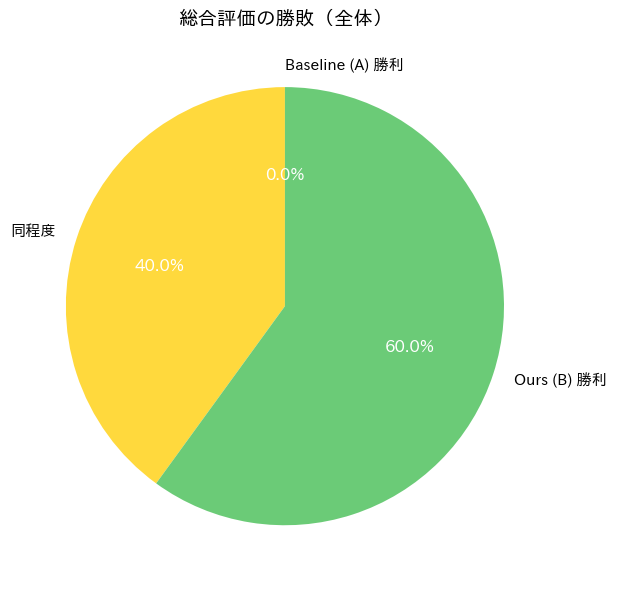

In [8]:
fig, ax = plt.subplots(figsize=(8, 6))

overall_data = summary_df.loc["overall"].values
labels = summary_df.loc["overall"].index
colors_pie = ["#FF6B6B", "#FFD93D", "#6BCB77"]

wedges, texts, autotexts = ax.pie(
    overall_data,
    labels=labels,
    autopct="%1.1f%%",
    colors=colors_pie,
    startangle=90,
    textprops={"fontsize": 11}
)

# パーセンテージのテキストを太字に
for autotext in autotexts:
    autotext.set_color("white")
    autotext.set_fontweight("bold")
    autotext.set_fontsize(12)

ax.set_title("総合評価の勝敗（全体）", fontsize=14, fontweight="bold")
plt.tight_layout()
plt.savefig("results/03_overall_pie.png", dpi=300, bbox_inches="tight")
plt.show()

## 8. 統計的有意性の簡易検定（符号検定）

In [9]:
from scipy import stats

print("\n=== 符号検定（統計的有意性） ===")
print("帰無仮説: A と B に差がない\n")

for field in rating_fields:
    score_col = f"{field}_score"
    # 同程度を除いて検定
    scores_nonzero = df[df[score_col] != 0][score_col].values

    if len(scores_nonzero) > 0:
        # 符号検定（2項検定）
        a_count = (scores_nonzero > 0).sum()
        n = len(scores_nonzero)
        p_value = stats.binomtest(a_count, n, 0.5, alternative="two-sided").pvalue

        significance = "*" if p_value < 0.05 else ""
        print(f"{field_labels[field]:10s}: p={p_value:.4f}  {significance}")


=== 符号検定（統計的有意性） ===
帰無仮説: A と B に差がない

有用性       : p=0.0002  *
可読性       : p=0.2188  
説得力       : p=0.0039  *
行動可能性     : p=0.0034  *
信頼性       : p=0.0010  *
総合評価      : p=0.0005  *


## 9. 参加者属性別の分析

In [10]:
# 九州大学学生の有無別
print("\n=== 九州大学学生の有無別 ===")
if "kyushu_student" in df.columns:
    for group in df["kyushu_student"].unique():
        subset = df[df["kyushu_student"] == group]
        avg_score = subset["overall_score"].mean()
        print(f"{group}: n={len(subset)}, 平均スコア={avg_score:+.3f}")

# 情報科学受講経験別
print("\n=== 情報科学受講経験別 ===")
if "info_course_taken" in df.columns:
    for group in df["info_course_taken"].unique():
        subset = df[df["info_course_taken"] == group]
        avg_score = subset["overall_score"].mean()
        print(f"{group}: n={len(subset)}, 平均スコア={avg_score:+.3f}")


=== 九州大学学生の有無別 ===
いいえ: n=20, 平均スコア=-1.000

=== 情報科学受講経験別 ===
いいえ: n=20, 平均スコア=-1.000


## 10. サマリーテーブルをCSVに保存

In [11]:
# 結果サマリーをCSVに保存
summary_df.to_csv("results/summary_wins.csv")

# 平均スコアをCSVに保存
avg_df = pd.DataFrame({
    "評価項目": [field_labels[f] for f in rating_fields],
    "平均スコア": [avg_scores[f] for f in rating_fields],
})
avg_df.to_csv("results/average_scores.csv", index=False)

print("✓ results/summary_wins.csv")
print("✓ results/average_scores.csv")
print("\n分析完了！")

✓ results/summary_wins.csv
✓ results/average_scores.csv

分析完了！
